In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()
from pinecone import Pinecone
from langchain_huggingface import HuggingFaceEmbeddings

In [3]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [4]:
pc = Pinecone(api_key=pinecone_api_key)
index_name = "10ms-db-bangla-book"

index = pc.Index(index_name)
index

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [6]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

In [8]:
# vector_store.add_documents()

In [9]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

In [10]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model=os.getenv("LLAMA_MODEL")
)

Rag Prompt

In [11]:
from langchain.prompts import PromptTemplate

rag_prompt = PromptTemplate(
    template=(
        "তুমি একজন সহায়ক বাংলা শিক্ষক। নিচের প্রশ্নটির উত্তর দিতে হবে শুধুমাত্র প্রদত্ত প্রাসঙ্গিক তথ্য ব্যবহার করে। "
        "যদি প্রশ্নের উত্তর নিচের প্রসঙ্গে না থাকে, তাহলে বিনয়ের সাথে বলবে যে উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই। "
        "অতিরিক্ত কিছু কল্পনা বা অনুমান করো না।\n\n"

        "প্রাসঙ্গিক প্রসঙ্গ:\n{context}\n\n"
        "প্রশ্ন:\n{question}\n\n"
        "উত্তর (বাংলায় সংক্ষিপ্ত এবং স্পষ্টভাবে দিন):"
    ),
    input_variables=["question", "context"],
)

In [12]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)


# display(Image(rag_chain.get_graph().draw_mermaid_png()))

Defining the Graph Workflow

In [14]:
from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage
from pydantic import Field
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    docs: str

RAG Node

In [15]:
def rag_node(state: State):
    print("--RAG Call--")
    
    question = state['messages'][0]
    print(question)
    
    
    
    rag_chain = (
        {
            "context": retriever | format_docs,
            "question": RunnablePassthrough()
        }
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    response = rag_chain.invoke(question)
    print("rag-response", response)
    
    return {
        "messages": [response]
    }

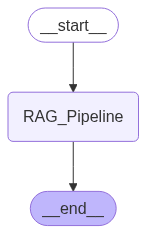

In [16]:
from langgraph.graph import START, StateGraph, END
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)

builder.add_node("RAG_Pipeline", rag_node)

builder.add_edge(START, "RAG_Pipeline")
builder.add_edge("RAG_Pipeline", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
config = {
    "configurable": {
        "thread_id": "chat_1"
    }
}

In [18]:
response = graph.invoke(
    {
        "messages": ["অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?"]
    },
    config=config
)

--RAG Call--
অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
rag-response উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই।


In [19]:
response["messages"][-1]

'উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই।'

In [20]:
graph.get_state(config=config).values

{'messages': ['অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?',
  'উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই।']}

Adding Long Term Memory

In [21]:
from pydantic import BaseModel, Field
from typing import List, Optional

class StudentProfile(BaseModel):
    """A profile for a student user to personalize interactions."""
    user_name: Optional[str] = Field(
        description="The student's name, if they mention it.",
        default=None
    )
    grade_or_class: Optional[str] = Field(
        description="The student's academic grade or class (e.g., 'Class 10', 'HSC Candidate').",
        default=None
    )
    topics_of_interest: List[str] = Field(
        description="A list of subjects or specific topics the student has asked about (e.g., 'কবিতা', 'অপরিচিতা', 'ব্যাকরণ').",
        default_factory=list
    )
    last_topic_discussed: Optional[str] = Field(
        description="The main topic of the last question asked by the user to maintain context.",
        default=None
    )

from trustcall import create_extractor

memory_extractor = create_extractor(
    llm,
    tools=[StudentProfile],
    tool_choice="StudentProfile",
)

from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage
import operator

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: The history of messages in the current conversation.
        docs: The documents retrieved from the vector store for the current question.
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    docs: list

from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver

# --- Node 1: Retrieve Documents ---
def retrieve_node(state: GraphState):
    """
    Retrieves documents from the vector store based on the latest user question.
    """
    print("---NODE: RETRIEVE DOCUMENTS---")
    last_message = state["messages"][-1]
    question = last_message.content
    
    # Use the retriever we defined earlier
    retrieved_docs = retriever.invoke(question)
    print(f"Retrieved {len(retrieved_docs)} docs.")
    
    return {"docs": retrieved_docs}

# --- Node 2: Generate Response using RAG and Memory ---
def generate_node(state: GraphState, config: dict, store: BaseStore):
    """
    Generates a response using the LLM, taking into account the retrieved docs,
    the conversation history, and the user's long-term memory.
    """
    print("---NODE: GENERATE RESPONSE---")
    
    # Get the latest question
    question = state["messages"][-1].content
    docs = state["docs"]
    
    # Get user_id from the config to load long-term memory
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    
    # Try to load existing student profile
    existing_memory = store.get(namespace, "student_profile")
    
    # Format the memories for the prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"ছাত্রের নাম: {memory_dict.get('user_name', 'অজানা')}\n"
            f"ছাত্রের শ্রেণি: {memory_dict.get('grade_or_class', 'অজানা')}\n"
            f"আগ্রহের বিষয়: {', '.join(memory_dict.get('topics_of_interest', ['কিছুই না']))}"
        )
    else:
        formatted_memory = "এই ছাত্রের জন্য কোনো স্মৃতি এখনো জমা হয়নি।"
        
    print(f"Loaded Memory: {formatted_memory}")

    # New prompt that incorporates long-term memory
    rag_with_memory_prompt = PromptTemplate(
        template=(
            "তুমি একজন সহায়ক ও ব্যক্তিগত বাংলা শিক্ষক। নিচের প্রশ্নটির উত্তর দেওয়ার জন্য প্রদত্ত প্রাসঙ্গিক তথ্য এবং ছাত্রের সম্পর্কে তোমার স্মৃতি ব্যবহার করো।\n\n"
            "## ছাত্রের স্মৃতি:\n{memory}\n\n"
            "## প্রাসঙ্গিক তথ্য:\n{context}\n\n"
            "## প্রশ্ন:\n{question}\n\n"
            "উত্তর (বাংলায় সংক্ষিপ্ত, ব্যক্তিগত এবং স্পষ্টভাবে দাও):"
        ),
        input_variables=["question", "context", "memory"],
    )

    # Chain for this node
    rag_chain = (
        {
            "context": lambda x: format_docs(x["documents"]),
            "question": lambda x: x["question"],
            "memory": lambda x: x["memory"]
        }
        | rag_with_memory_prompt
        | llm
        | StrOutputParser()
    )
    
    # Invoke the chain with all necessary info
    response = rag_chain.invoke({
        "documents": docs,
        "question": question,
        "memory": formatted_memory
    })
    
    print(f"Generated Response: {response}")
    
    return {"messages": [AIMessage(content=response)]}

In [22]:
# --- Node 3: Update Long-Term Memory (CORRECTED) ---
def update_memory_node(state: GraphState, config: dict, store: BaseStore):
    """
    Reflects on the most recent exchange and updates the student's profile in the long-term store.
    """
    print("---NODE: UPDATE MEMORY---")
    
    # Get user_id from the config
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    
    # Load existing memory
    existing_memory = store.get(namespace, "student_profile")
    existing_profile = {"StudentProfile": existing_memory.value} if existing_memory else None
    
    # Instruction for the extractor
    extraction_instruction = "নিচের কথোপকথন থেকে ছাত্রের প্রোফাইল তৈরি বা আপডেট করো:"
    
    recent_exchange = state["messages"][-2:]
    
    # Invoke the extractor with the FOCUSED context
    result = memory_extractor.invoke({
        "messages": [SystemMessage(content=extraction_instruction)] + recent_exchange,
        "existing": existing_profile
    })
    
    if result.get("responses"):
        updated_profile = result["responses"][0].model_dump()
        print(f"Updated Profile: {updated_profile}")

        # Save the updated profile to the long-term store
        store.put(namespace, "student_profile", updated_profile)
    else:
        print("No new profile information found to update.")
    return

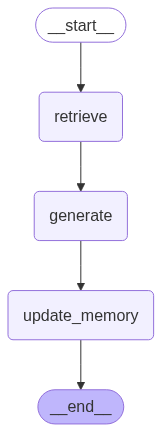

In [23]:
## **Building the Graph**
from langgraph.graph import StateGraph, START, END
from langgraph.store.memory import InMemoryStore
from IPython.display import display, Image

# The store for long-term (across-thread) memory
long_term_store = InMemoryStore()

# The checkpointer for short-term (within-thread) memory
checkpointer = MemorySaver()

# Define the graph
builder = StateGraph(GraphState)

# Add the nodes
builder.add_node("retrieve", retrieve_node)
builder.add_node("generate", generate_node)
builder.add_node("update_memory", update_memory_node)

# Define the edges (the flow)
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", "update_memory")
builder.add_edge("update_memory", END)

# Compile the graph with both memory systems
graph = builder.compile(checkpointer=checkpointer, store=long_term_store)

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [24]:
config_user_1 = {
    "configurable": {
        "user_id": "student_nahid",
        "thread_id": "chat_session_1" 
    }
}

# --- First Interaction ---
print("\n--- FIRST INTERACTION (SESSION 1) ---")
question1 = "আমার নাম Nahid Hasan, আমি দশম শ্রেণিতে পড়ি। 'অপরিচিতা' গল্পে অনুপমের মামার চরিত্রটি কেমন?"

response = graph.invoke(
    {"messages": [HumanMessage(content=question1)]},
    config=config_user_1
)

print("\nFinal Answer:", response['messages'][-1].content)


--- FIRST INTERACTION (SESSION 1) ---
---NODE: RETRIEVE DOCUMENTS---
Retrieved 3 docs.
---NODE: GENERATE RESPONSE---
Loaded Memory: এই ছাত্রের জন্য কোনো স্মৃতি এখনো জমা হয়নি।
Generated Response: নাহিদ হাসান, দশম শ্রেণির ছাত্র। তোমার প্রশ্নের জন্য, আমি সাহিত্য বিভাগ থেকে 'অপরিচিতা' গল্পটি সম্পর্কে জ্ঞান ব্যবহার করব। 

'অপরিচিতা' গল্পে, অনুপমের মামা একটি গুরুত্বপূর্ণ চরিত্র। অনুপমের মামা রায় চৌধুরী ছিলেন একজন কৌলিন্য-অহংকারী, অত্যন্ত গর্বিত মানুষ। সমাজে তাঁর বেশ প্রতিপত্তি ছিল। তিনি লোকসমাজে মিশতে ভালোবাসতেন না। একসময় গ্রামের রাস্তায় এক রিকশাওয়ালাকে তিনি অপমান করেছিলেন। রিকশাওয়ালা তাকে অপমানের জবাব দিয়েছিল। এতে রায় চৌধুরী তার গর্বিত মন নিয়ে বেদনার্দ্র হয়ে পড়েছিলেন। 

এই চরিত্রটি গল্পে একটি বিশেষ ভূমিকা পালন করেছে। তোমার পাঠ্যপুস্তকের বাইরে সাহিত্য সম্পর্কে আর জানতে চাও?
---NODE: UPDATE MEMORY---
Updated Profile: {'user_name': 'Nahid Hasan', 'grade_or_class': 'Class10', 'topics_of_interest': ['अपरिचिता'], 'last_topic_discussed': 'অপरिचिता गल्पे अनुपमेर मामार चरित्र'}

Final Ans

In [25]:
question1 = "অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?"

response = graph.invoke(
    {"messages": [HumanMessage(content=question1)]},
    config=config_user_1
)

print("\nFinal Answer:", response['messages'][-1].content)

---NODE: RETRIEVE DOCUMENTS---
Retrieved 3 docs.
---NODE: GENERATE RESPONSE---
Loaded Memory: ছাত্রের নাম: Nahid Hasan
ছাত্রের শ্রেণি: Class10
আগ্রহের বিষয়: अपरिचिता
Generated Response: Nahid Hasan, তোমার প্রশ্নের উত্তর হলো: 

সুপুরুষ: যে পুরুষের চেহারা ও গুণাবলি অনুপম তাকে সুপুরুষ বলা হয়।

উদाहरण: রাষ্ট্রপতি নেলসন ম্যান্ডেলা সুপুরুষ ছিলেন।
---NODE: UPDATE MEMORY---
Updated Profile: {'user_name': 'Nahid Hasan', 'grade_or_class': 'Class10', 'topics_of_interest': ['अपरिचिता'], 'last_topic_discussed': 'অনুপমের ভাষায় সুপুরুষ'}

Final Answer: Nahid Hasan, তোমার প্রশ্নের উত্তর হলো: 

সুপুরুষ: যে পুরুষের চেহারা ও গুণাবলি অনুপম তাকে সুপুরুষ বলা হয়।

উদाहरण: রাষ্ট্রপতি নেলসন ম্যান্ডেলা সুপুরুষ ছিলেন।


In [27]:
print("\n\n--- SECOND INTERACTION (NEW SESSION) ---")

# Note: We use a *new thread_id* but the *same user_id*
config_user_1_new_session = {
    "configurable": {
        "user_id": "student_nimat",
        "thread_id": "chat_session_2" # New session
    }
}

question2 = "আমি আগে কোন বিষয় নিয়ে প্রশ্ন করেছিলাম? এখন bolo কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে"

response2 = graph.invoke(
    {"messages": [HumanMessage(content=question2)]},
    config=config_user_1_new_session
)

print("\nFinal Answer:", response2['messages'][-1].content)

# Check the long-term memory again to see it updated
print("\n--- CHECKING LONG-TERM MEMORY (AFTER 2nd INTERACTION) ---")
nimat_profile_updated = long_term_store.get(("memory", "student_nimat"), "student_profile")
print(nimat_profile_updated.value)



--- SECOND INTERACTION (NEW SESSION) ---


---NODE: RETRIEVE DOCUMENTS---
Retrieved 3 docs.
---NODE: GENERATE RESPONSE---
Loaded Memory: এই ছাত্রের জন্য কোনো স্মৃতি এখনো জমা হয়নি।
Generated Response: আগে আপনি কোনো প্রশ্ন করেননি।

উপরের প্রসঙ্গ থেকে বোঝা যাচ্ছে যে, অনুপমের ভাগ্য দেবতা কে তা উল্লেখ করা হয়নি। তবে, প্রাসঙ্গিক তথ্যাংশে বর্ণিত ঘটনাটি নেলসন ম্যান্ডেলার আত্মজীবনী ‘লং ওয়াক টু ফ্রিডম’ থেকে নেওয়া হয়েছে। এখানে তিনি তার উদ্বোধনী অনুষ্ঠান সম্পর্কে আলোচনা করেছেন। আর এই অনুষ্ঠানে তিনি তার দুই জাতীয় সঙ্গীত গাওয়ার কথা উল্লেখ করেছেন। এখানে কোনো ভাগ্য দেবতার উল্লেখ নেই।

তাই উত্তরটি হবে: বলা যায়, এখানে অনুপমের ভাগ্য দেবতা কে তা উল্লেখ করা হয়নি।
---NODE: UPDATE MEMORY---
Updated Profile: {'user_name': None, 'grade_or_class': None, 'topics_of_interest': [], 'last_topic_discussed': None}

Final Answer: আগে আপনি কোনো প্রশ্ন করেননি।

উপরের প্রসঙ্গ থেকে বোঝা যাচ্ছে যে, অনুপমের ভাগ্য দেবতা কে তা উল্লেখ করা হয়নি। তবে, প্রাসঙ্গিক তথ্যাংশে বর্ণিত ঘটনাটি নেলসন ম্যান্ডেলার আত্মজীবনী ‘লং ওয়াক টু ফ্রিডম’ থেকে নেওয়া হয়েছে। এখানে তিনি ত

In [28]:
print("\nFinal Answer:", response2['messages'][-1].content)


Final Answer: আগে আপনি কোনো প্রশ্ন করেননি।

উপরের প্রসঙ্গ থেকে বোঝা যাচ্ছে যে, অনুপমের ভাগ্য দেবতা কে তা উল্লেখ করা হয়নি। তবে, প্রাসঙ্গিক তথ্যাংশে বর্ণিত ঘটনাটি নেলসন ম্যান্ডেলার আত্মজীবনী ‘লং ওয়াক টু ফ্রিডম’ থেকে নেওয়া হয়েছে। এখানে তিনি তার উদ্বোধনী অনুষ্ঠান সম্পর্কে আলোচনা করেছেন। আর এই অনুষ্ঠানে তিনি তার দুই জাতীয় সঙ্গীত গাওয়ার কথা উল্লেখ করেছেন। এখানে কোনো ভাগ্য দেবতার উল্লেখ নেই।

তাই উত্তরটি হবে: বলা যায়, এখানে অনুপমের ভাগ্য দেবতা কে তা উল্লেখ করা হয়নি।
